## Predicting whether a passenger will accept a coupon in the [In-Vehicle Coupon Recommendation](https://archive.ics.uci.edu/dataset/603/in+vehicle+coupon+recommendation) dataset.

The automotive industry is rapidly evolving, making personalized marketing strategies essential for enhancing customer engagement and boosting sales. In-vehicle coupon recommendation systems tailored to individual preferences and behaviors have proven to significantly influence purchasing decisions, fostering both customer loyalty and revenue growth.

In this project, we leverage CatBoost, a high-performance gradient boosting library, and Stratified K-Fold cross-validation to develop a robust recommendation system. Through meticulous data preprocessing and validation techniques, our goal is to optimize model performance and deliver highly accurate, actionable coupon recommendations. This approach highlights the potential of machine learning in shaping the future of automotive marketing.

This data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether they will accept the coupon if they are the driver. <br>
For more information about the dataset, please refer to the paper:
Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry MacNeille. 'A Bayesian framework for learning rule sets for interpretable classification.' The Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393.

### Part 1: Loading and Preparing Data <br>
In this section, we will load the dataset and conduct exploratory data analysis (EDA). The goal is to identify any notable characteristics or potential issues within the dataset that could impact its suitability for model training. We will also preprocess and structure the data to ensure it is clean, consistent, and ready for use in building and training the model.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')

In [ ]:
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [ ]:
# Convert time AM/PM to 24-hour integer format
def convert_to_24hr_int(time_str):
    return pd.to_datetime(time_str, format='%I%p').hour

df['time'] = df['time'].apply(convert_to_24hr_int)

In [ ]:
df.head(5)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,14,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,14,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,14,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  int64 
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [ ]:
df.describe()

,temperature,time,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,13.820246,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,5.409146,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,7.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,10.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,14.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,18.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,22.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.shape

(12684, 26)

In [ ]:
print(df.isna().sum())

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64


In [ ]:
# Drop 'car' column due to high number of missing values
df.drop('car', inplace=True, axis=1)

In [ ]:
from sklearn.impute import SimpleImputer

# Separate categorical and numeric columns
categorical_cols = df.select_dtypes(include=['object']).columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Impute missing values
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')

df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# select numeric variables
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols
vif_data["VIF"] = [variance_inflation_factor(df[numeric_cols].values, i) for i in range(len(numeric_cols))]
print(vif_data)


             feature       VIF
0        temperature  1.069226
1               time  1.046948
2       has_children  1.010657
3   toCoupon_GEQ5min  0.000000
4  toCoupon_GEQ15min  1.217590
5  toCoupon_GEQ25min  1.219892
6     direction_same       inf
7      direction_opp       inf
8                  Y  1.017096


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



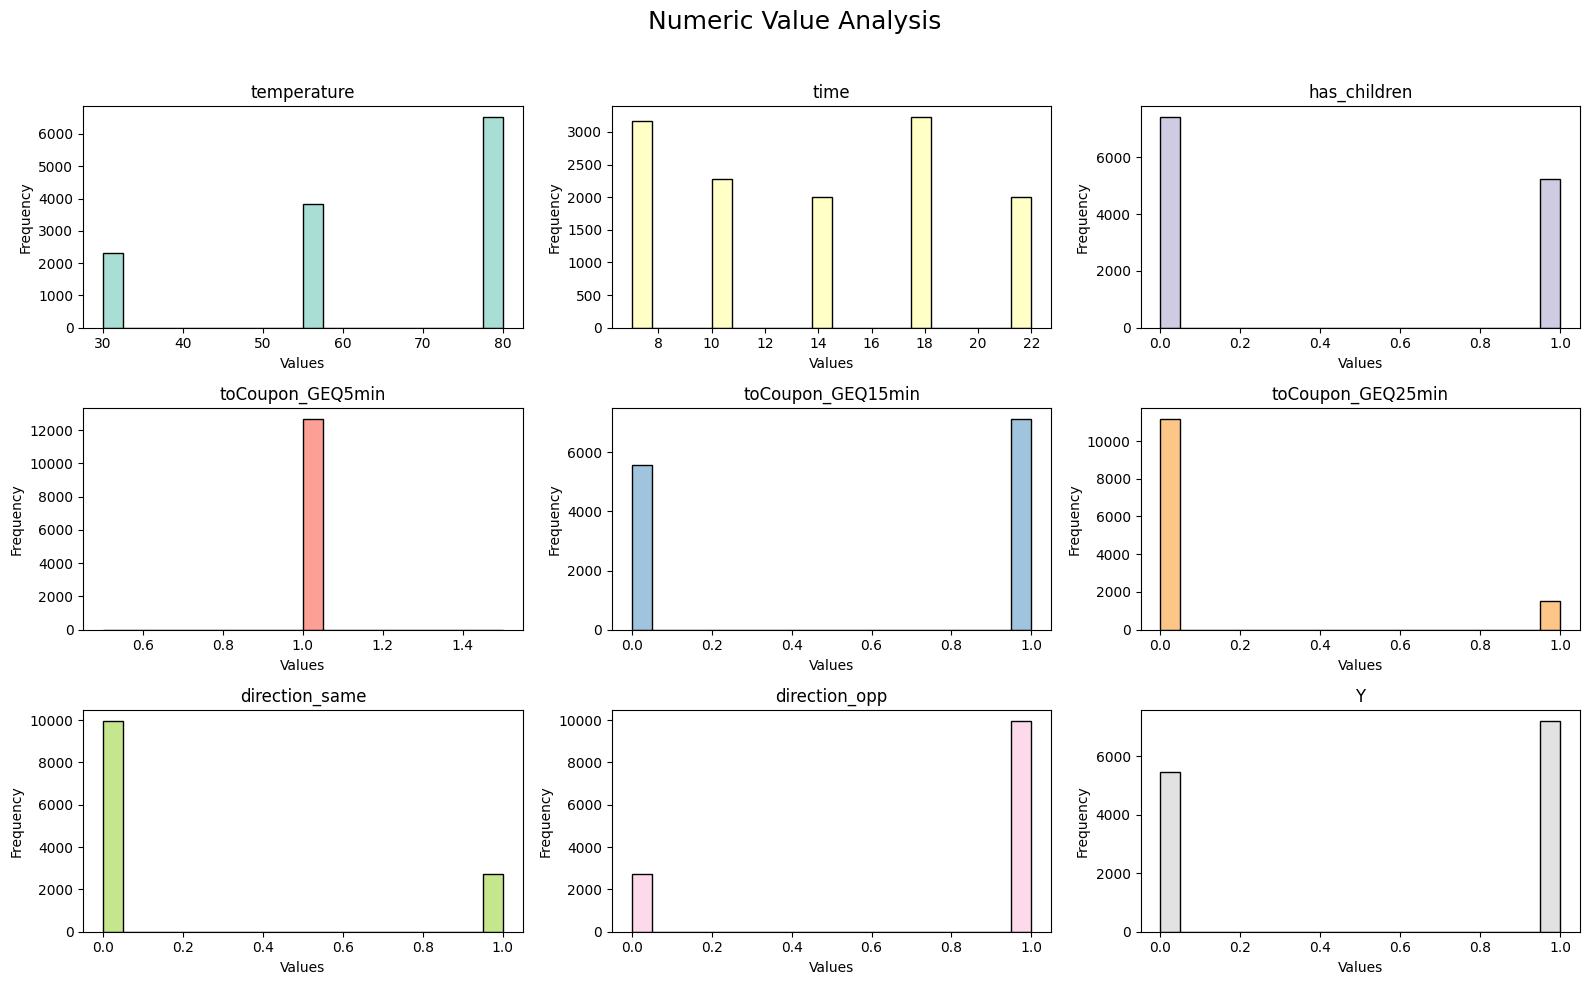

In [ ]:
# Select only numeric columns and store them in a list
numeric_cols = df.select_dtypes(include=['number']).columns

# Set color palette (each histogram will have a different color)
colors = sns.color_palette('Set3', len(numeric_cols))

# Plot histograms for numeric columns
plt.figure(figsize=(16, 10))

# Loop through each numeric column to create histograms
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  # Set up a 3x3 subplot layout
    sns.histplot(df[col], kde=False, bins=20, edgecolor='black', color=colors[i-1])
    plt.title(col)
    plt.xlabel('Values')
    plt.ylabel('Frequency')

# Add a title for the entire figure
plt.suptitle('Numeric Value Analysis', fontsize=18)

# Adjust layout to prevent overlapping of the title and subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])

Columns with numeric value have 2 numeric values (either '0' or '1') except for "Temperature" which has 80/55/30 for its value, and "toCoupon_GEQ5min" which has '1' for all its value. Since 'toCoupon_GEQ5min' has only one unique variable, it won't help much in the encoding of the categorical variables. Therefore, its better to drop that column.

In [ ]:
# Drop columns with constant values
df.drop(columns=['toCoupon_GEQ5min'], inplace=True)

In [ ]:
import plotly.graph_objects as go

# Function to calculate the acceptance probability for a column
def calculate_probability(df, col):
    prob = df[df['Y'] == 1][col].value_counts() / df[col].value_counts() * 100
    return prob.index, prob.values

# Calculate probabilities for direction_same and direction_opp
same_idx, same_val = calculate_probability(df, 'direction_same')
opp_idx, opp_val = calculate_probability(df, 'direction_opp')

# Create a bar plot for same and opposite directions
fig = go.Figure()

# Add bars for direction_same
fig.add_trace(go.Bar(
    x=same_idx,
    y=same_val,
    name='Same Direction',
    marker_color='blue'
))

# Add bars for direction_opp
fig.add_trace(go.Bar(
    x=opp_idx,
    y=opp_val,
    name='Opposite Direction',
    marker_color='orange'
))

# Update layout for the figure
fig.update_layout(
    title="Coupon Acceptance Probability: Same vs Opposite Direction",
    xaxis_title="Direction",
    yaxis_title="Acceptance Probability (%)",
    barmode='group',
    height=400,
    width=600
)

fig.show()

In [ ]:
from scipy.stats import chi2_contingency

# Function to calculate correlation and chi-square test
def evaluate_variable(df, col, target):
    # Calculate correlation
    corr = df[[col, target]].corr().iloc[0, 1]

    # Perform Chi-Square test
    contingency_table = pd.crosstab(df[col], df[target])
    chi2, p, _, _ = chi2_contingency(contingency_table)

     # Print results
    print(f"Variable: {col}")
    print(f"  Correlation with {target}: {corr:.4f}")
    print(f"  Chi-Square Test p-value: {p:.4f}")
    print(f"  Conclusion: {'Not significant (drop)' if p > 0.05 else 'Significant (keep)'}\n")
    return corr, p

# Evaluate both variables
evaluate_variable(df, 'direction_same', 'Y')
evaluate_variable(df, 'direction_opp', 'Y')

Variable: direction_same
  Correlation with Y: 0.0146
  Chi-Square Test p-value: 0.1054
  Conclusion: Not significant (drop)

Variable: direction_opp
  Correlation with Y: -0.0146
  Chi-Square Test p-value: 0.1054
  Conclusion: Not significant (drop)



(-0.014570297624930981, 0.10541990881286277)

Based on the contigency table and probability analysis, the frequency between same direction and opposite dirrection to the coupon acceptance (Y) is slightly different. In addition, Both of the variable are not statisticaly correlated with the coupon acceptance.

In [ ]:
# Drop columns with directions
df.drop(columns=['direction_same','direction_opp'], inplace=True)

In [ ]:
# list the object columns
object_cols = df.select_dtypes(include='object').columns.to_list()
print(object_cols)

['destination', 'passanger', 'weather', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']


When we explore the object columns, we can divide them into binary, categorical(more then 3 categories) or ordinal. <br>
1. binary columns: "gender", "expiration"
- expiration: 1d, 2h (the coupon expires in 1 day or in 2 hours)
- gender: Female, Male
2. categorical columns:'destination', 'passenger', weather', 'coupon', 'maritalStatus', 'occupation'
- destination: No Urgent Place, Home, Work
- passanger: Alone, Friend(s), Kid(s), Partner (who are the passengers in the car)
- weather: Sunny, Rainy, Snowy
- coupon: Restaurant(<$20), Coffee House, Carry out & Take away, Bar, Restaurant($20-$50)
- maritalStatus: Unmarried partner, Single, Married partner, Divorced, Widowed
- occupation: Unemployed, Architecture & Engineering, Student,
Education&Training&Library, ..., Farming Fishing & Forestry

3. categorical variables that are ordinal: 'age', 'education', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50'
- age: 21, 46, 26, 31, 41, 50plus, 36, below21
- education: Some college - no degree, Bachelors degree, Associates degree, High School Graduate, Graduate degree (Masters or Doctorate), Some High School
- income: $37,500 - $49,999, $62500 - $74999,..., $87500 - $99999, Less than $12500

- Bar: never, less1, 1~3, gt8, nan4~8 (feature meaning: how many times do you go to a bar every month?)
- CoffeeHouse: ...
- CarryAway: ...
- RestaurantLessThan20: 4~8, 1~3, less1, gt8, never (feature meaning: how many times do you go to a restaurant with an average expense per person of less than $20 every month?)
- Restaurant20To50: ...

I will use one hot encoding for categorical values, and label encoding for ordinal values and binary values.



### Label encoding for: age, education, income, Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50 & gender, expiration

In [ ]:
# let's apply label encoding to 'age'
age_order = ['below21', '21', '26', '31', '36', '41', '46', '50plus']
df['age'] = pd.Categorical(df['age'], categories=age_order, ordered=True)
df['age_encoded'] = df['age'].cat.codes

In [ ]:
# let's apply label encoding to 'education'
education_order = ['Some High School', 'High School Graduate', 'Associates degree', 'Some college - no degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)']
df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)
df['education_encoded'] = df['education'].cat.codes

In [ ]:
# let's apply label encoding to 'income'
income_order = [
    'Less than $12500',
    '$12500 - $24999',
    '$25000 - $37499',
    '$37500 - $49999',
    '$50000 - $62499',
    '$62500 - $74999',
    '$75000 - $87499',
    '$87500 - $99999',
    '$100000 or More'
]
df['income'] = pd.Categorical(df['income'], categories=income_order, ordered=True)
df['income_encoded'] = df['income'].cat.codes

In [ ]:
# let's apply label encoding to columns that have the same categorical values structure all at once
columns_to_encode = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
category_order = ['never', 'less1', '1~3', '4~8', 'gt8']

# let's create a loop
for col in columns_to_encode:
    df[col] = pd.Categorical(df[col], categories=category_order, ordered=True)
    df[col + '_encoded'] = df[col].cat.codes

# check samples
print(df[['Bar', 'Bar_encoded', 'CoffeeHouse', 'CoffeeHouse_encoded']].sample(3))

         Bar  Bar_encoded CoffeeHouse  CoffeeHouse_encoded
12390    1~3            2       less1                    1
979    less1            1       less1                    1
8356   never            0       never                    0


<ipython-input-87-bf552a115a39>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-87-bf552a115a39>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-87-bf552a115a39>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-87-bf552a115a39>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-87-bf552a115a39>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and wi

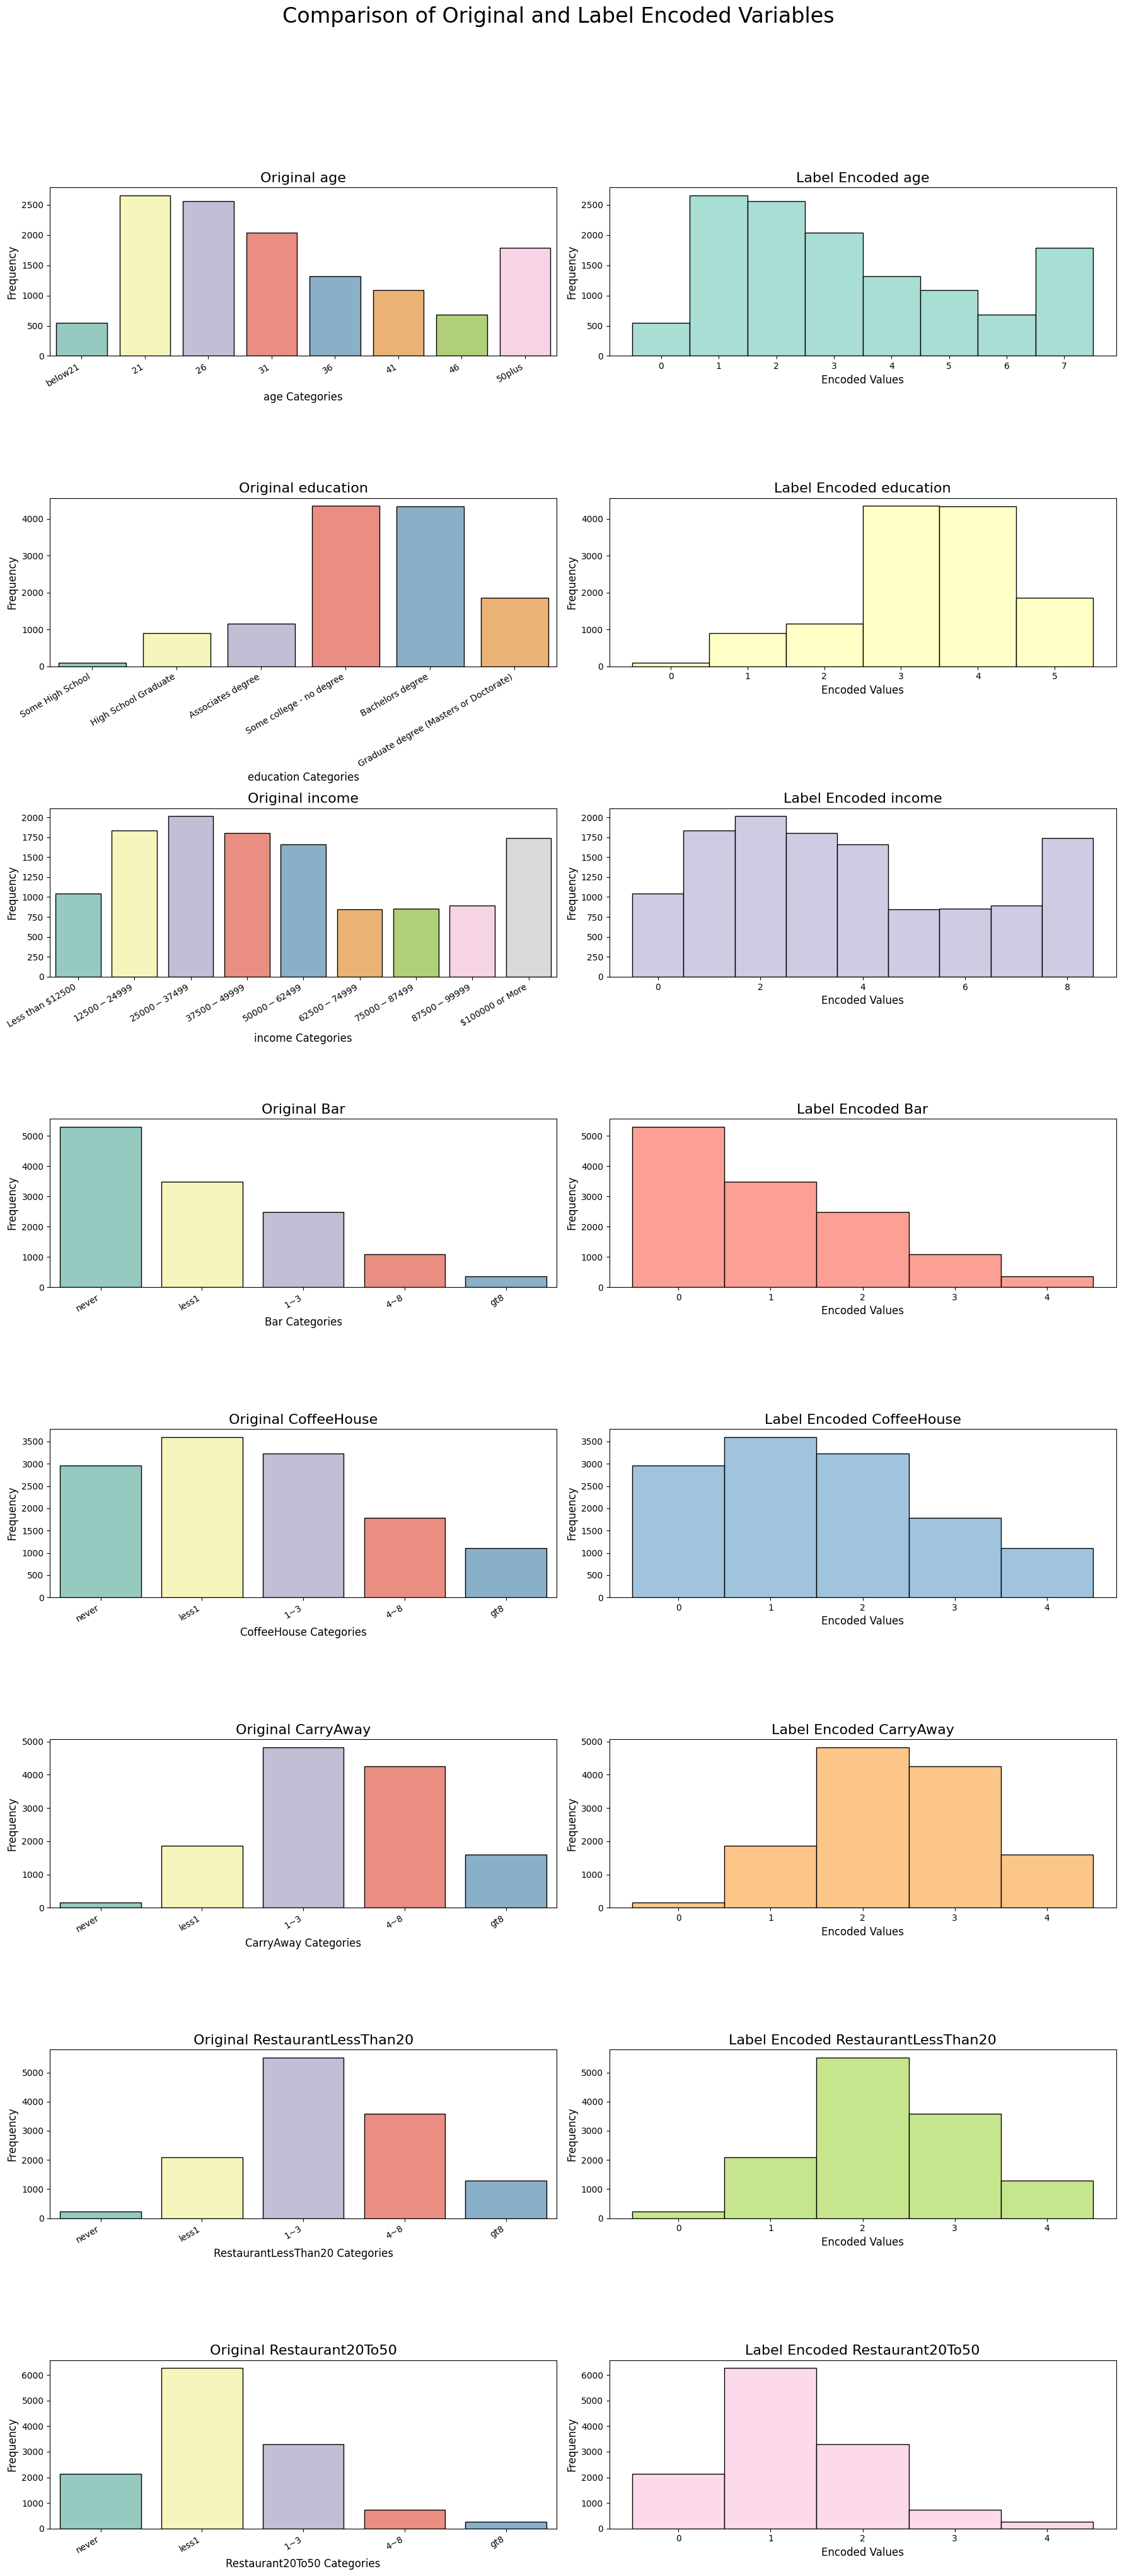

In [ ]:
# Columns to apply Label Encoding
columns_to_encode = ['age', 'education', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
                     'RestaurantLessThan20', 'Restaurant20To50']

# Set up the figure size
plt.figure(figsize=(18, len(columns_to_encode) * 5))  # Adjust height dynamically
colors = sns.color_palette('Set3', len(columns_to_encode))  # Unique colors for columns

# Loop through each column to visualize original and encoded distributions
for i, col in enumerate(columns_to_encode, 1):
    # Left: Original categorical values
    plt.subplot(len(columns_to_encode), 2, 2*i-1)
    sns.countplot(data=df, x=col, palette='Set3', edgecolor='black')
    plt.title(f'Original {col}', fontsize=16)
    plt.xlabel(f'{col} Categories', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=30, ha='right')

    # Right: Label Encoded values
    df[col + '_encoded'] = pd.Categorical(df[col]).codes  # Apply Label Encoding
    plt.subplot(len(columns_to_encode), 2, 2*i)
    sns.histplot(df[col + '_encoded'], bins=len(df[col].unique()), edgecolor='black', color=colors[i-1], discrete=True)
    plt.title(f'Label Encoded {col}', fontsize=16)
    plt.xlabel('Encoded Values', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

# Add a main title for the entire figure
plt.suptitle('Comparison of Original and Label Encoded Variables', fontsize=24, y=1.02)

# Adjust layout to avoid overlapping of subplots
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:
# Drop the original ordninal columns after encoding
columns_to_drop = ['age', 'education', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

# Use drop() to remove these columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Binary encoding
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['expiration'] = df['expiration'].map({'1d': 1, '2h': 0})

We will simplify the occupation column by grouping infrequent categories into a single category, "Other." This reduces the number of unique categories in the dataset, making it easier to analyze and model. Categories with a frequency greater than 500 are retained, while those with 500 or fewer occurrences are replaced with "Other."

In [ ]:
df['occupation'] = df['occupation'].apply(lambda x: x if df['occupation'].value_counts()[x] > 500 else 'Other')

In [ ]:
df['occupation'].unique()

array(['Unemployed', 'Other', 'Student', 'Education&Training&Library',
       'Sales & Related', 'Management',
       'Arts Design Entertainment Sports & Media',
       'Computer & Mathematical', 'Office & Administrative Support',
       'Business & Financial'], dtype=object)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Specify the categorical columns to encode
categorical_columns = ['destination', 'passanger', 'weather', 'coupon', 'maritalStatus', 'occupation']

# Initialize the OneHotEncoder with the correct parameter
encoder = OneHotEncoder(sparse_output=False)

# Perform one-hot encoding and convert to DataFrame
encoded_data = encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded columns with the original DataFrame (excluding the original categorical columns)
df = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

In [ ]:
pd.set_option('display.max_columns', None)
df

,temperature,time,expiration,gender,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,Y,age_encoded,education_encoded,income_encoded,Bar_encoded,CoffeeHouse_encoded,CarryAway_encoded,RestaurantLessThan20_encoded,Restaurant20To50_encoded,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,coupon_Bar,coupon_Carry out & Take away,coupon_Coffee House,coupon_Restaurant(20-50),coupon_Restaurant(<20),maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,occupation_Arts Design Entertainment Sports & Media,occupation_Business & Financial,occupation_Computer & Mathematical,occupation_Education&Training&Library,occupation_Management,occupation_Office & Administrative Support,occupation_Other,occupation_Sales & Related,occupation_Student,occupation_Unemployed
0,55.0,14.0,1,0,1.0,0.0,0.0,1.0,1,3,3,0,0,2,3,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,80.0,10.0,0,0,1.0,0.0,0.0,0.0,1,3,3,0,0,2,3,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,80.0,10.0,0,0,1.0,1.0,0.0,1.0,1,3,3,0,0,2,3,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,80.0,14.0,0,0,1.0,1.0,0.0,0.0,1,3,3,0,0,2,3,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,80.0,14.0,1,0,1.0,1.0,0.0,0.0,1,3,3,0,0,2,3,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,55.0,18.0,1,1,0.0,0.0,0.0,1.0,2,4,6,0,0,2,3,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12680,55.0,7.0,1,1,0.0,0.0,0.0,1.0,2,4,6,0,0,2,3,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12681,30.0,7.0,1,1,0.0,0.0,0.0,0.0,2,4,6,0,0,2,3,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12682,30.0,7.0,1,1,0.0,1.0,1.0,0.0,2,4,6,0,0,2,3,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0



The original dataset consisted of 26 columns. After removing unnecessary columns and transforming categorical variables through one-hot encoding and label encoding, the dataset now contains a total of 46 columns. Using this preprocessed data, we will proceed to train the model in Part 2.

### Part 2: Training & Choosing Models <br>
In this section, we will train different types of predictive model for the task of predicting whether the coupon is accepted, and choose the best functioning one.


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = 'Y')
y = df.Y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, roc_auc_score
import pandas as pd

# Define a dictionary of models
models = {
    'LogisticRegression': LogisticRegression,
    'DecisionTree': DecisionTreeClassifier,
    'RandomForest': RandomForestClassifier,
    'GradientBoosting': GradientBoostingClassifier,
    'LGBM': LGBMClassifier,
    'XGBoost': XGBClassifier,
    'AdaBoost': AdaBoostClassifier,
    'CatBoost': CatBoostClassifier
}

# Function to clean feature names
def clean_feature_names(dataframe):
    dataframe.columns = [
        col.replace(" ", "_").replace("[", "_").replace("]", "_").replace("<", "_")
        for col in dataframe.columns
    ]
    return dataframe

# Function to compare model performance
def find_model(models, X_train, y_train, X_test, y_test):
    results = []

    for name, model in models.items():
        if name == 'LogisticRegression':
            clf = make_pipeline(StandardScaler(), model(random_state=212))
        else:
            clf = model(random_state=212)

        # Train and predict with the model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else None

        # Calculate performance metrics
        acc = balanced_accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

        # Store results
        results.append({
            'Model': name,
            'Balanced Accuracy': acc,
            'Recall': recall,
            'Precision': precision,
            'ROC AUC': roc_auc
        })

    # Convert results to a DataFrame
    return pd.DataFrame(results)

# Clean feature names in the DataFrame
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

# Execute the find_model function
result = find_model(models, X_train, y_train, X_test, y_test)
print(result)


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




[LightGBM] [Info] Number of positive: 5801, number of negative: 4346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 10147, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571696 -> initscore=0.288774
[LightGBM] [Info] Start training from score 0.288774
Learning rate set to 0.02771
0:	learn: 0.6876464	total: 67.4ms	remaining: 1m 7s
1:	learn: 0.6823035	total: 92.6ms	remaining: 46.2s
2:	learn: 0.6778737	total: 119ms	remaining: 39.4s
3:	learn: 0.6732003	total: 159ms	remaining: 39.5s
4:	learn: 0.6686284	total: 187ms	remaining: 37.2s
5:	learn: 0.6646512	total: 228ms	remaining: 37.8s
6:	learn: 0.6612492	total: 248ms	remaining: 35.2s
7:	learn: 0.6580493	total: 277ms	remaining: 34.3s
8:	learn: 0.6546


Both CatBoost and XGBoost show good performance in predicting whether a passenger will accept a coupon in the In-Vehicle Coupon Recommendation dataset. However, we will choose CatBoost because it is better suited for handling categorical data directly without requiring extensive preprocessing, such as one-hot encoding. This makes the data pipeline simpler and reduces the risk of overfitting. Additionally, CatBoost demonstrates superior performance in Recall (0.836) and ROC AUC (0.834), which aligns with our goal of maximizing customer engagement by minimizing missed opportunities to identify passengers likely to accept a coupon. Moreover, CatBoost provides interpretable feature importance, which is critical for deriving actionable insights and enhancing personalized marketing strategies. While XGBoost performs slightly better in terms of Precision (0.765), the primary objective of this project is to optimize Recall and overall model robustness, making CatBoost the more suitable choice.

### Part 3: Model Training with CatBoost and Cross-Validation <br>
In this part, I focus on training the CatBoostClassifier using Stratified K-Fold cross-validation to ensure the model generalizes well to unseen data. This technique splits the data into training and validation sets across multiple folds while maintaining the distribution of the target variable in each fold. By using this method, I obtain a more reliable evaluation of the model's performance and reduce the risk of overfitting.

### Process Overview: <br>
- Handling Categorical Features and Missing Values: Categorical features were explicitly defined, allowing CatBoost to leverage its native handling of such data. Missing values were filled with "missing" to ensure no empty entries affected the model's performance.

- Cross-Validation Initialization: I initialized Stratified K-Fold with 5 splits, shuffling, and a fixed random state for reproducibility. This ensures each fold is representative of the overall dataset, maintaining the balance of the target variable across all folds.

- Model Configuration: The CatBoostClassifier is configured with specific hyperparameters. It is also enabled with early_stopping_rounds=50, halting training if no improvement is observed on the validation set for 50 consecutive rounds, preventing unnecessary computation and reducing overfitting.

- Training and Evaluation: For each fold, the model is trained on the training subset and evaluated on the validation subset. The F1 score was computed for each fold, balancing Precision (how accurate predictions are) and Recall (how well the model identifies all relevant instances). The F1 score was chosen because it provides a single metric that balances both these aspects, which is critical when the goal is to maximize engagement while minimizing missed opportunities.

- Aggregating Results: After processing all folds, the average F1 score across all folds was calculated, offering an overall measure of the model's effectiveness.

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

In [ ]:
data = pd.read_csv('in-vehicle-coupon-recommendation.csv')

In [ ]:
# Identify categorical features
cat_features = data.select_dtypes(include=["object"]).columns.tolist()

# Handle missing values in categorical features
for col in cat_features:
    data[col] = data[col].fillna("missing").astype(str)

# Split data into features (X) and target (y)
X = data.drop("Y", axis=1)  # Replace 'Y' with your target column name if different
y = data["Y"]

# Initialize Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store F1 scores for each fold
f1_scores = []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    # Split data into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Initialize and configure the CatBoost Classifier
    model = CatBoostClassifier(
        iterations=1000,               # Number of boosting iterations
        learning_rate=0.05,            # Learning rate
        depth=6,                       # Depth of the trees
        l2_leaf_reg=3,                 # L2 regularization coefficient
        random_strength=1,             # Random strength parameter
        cat_features=cat_features,     # List of categorical feature names
        random_seed=42,                # Seed for reproducibility
        verbose=False,                 # Suppress training output
        early_stopping_rounds=50       # Stop training if no improvement after 50 rounds
    )

    # Train the model
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Calculate F1 score for the current fold
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)
    print(f"Fold {fold} F1 Score: {f1:.4f}")

# Calculate and print the average F1 score across all folds
print(f"\nAverage F1 Score: {np.mean(f1_scores):.4f}")

Fold 1 F1 Score: 0.7960
Fold 2 F1 Score: 0.8075
Fold 3 F1 Score: 0.7961
Fold 4 F1 Score: 0.8066
Fold 5 F1 Score: 0.8017

Average F1 Score: 0.8016


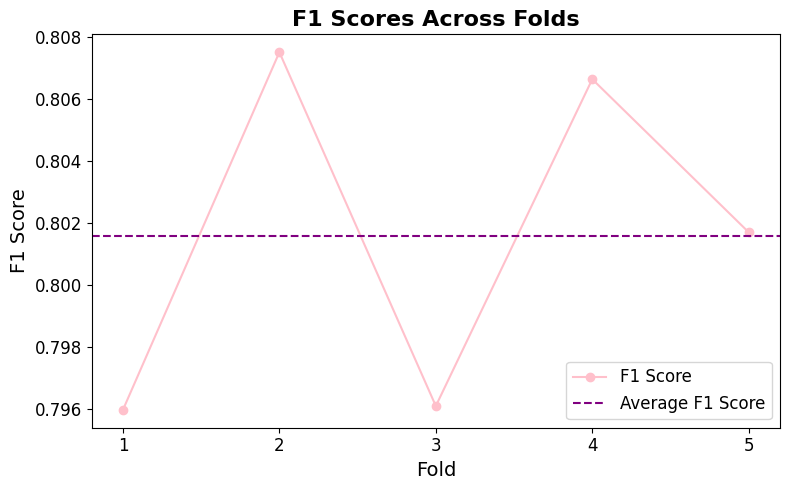

In [ ]:
import matplotlib.pyplot as plt

# Visualize F1 scores across folds with customized styling
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o', linestyle='-', color='pink', label='F1 Score')
plt.axhline(y=np.mean(f1_scores), color='purple', linestyle='--', label='Average F1 Score')

# Customize ticks and remove grid
plt.xticks(range(1, len(f1_scores) + 1), fontsize=12)  # Show only integers for folds
plt.yticks(fontsize=12)
plt.title('F1 Scores Across Folds', fontsize=16, fontweight='bold')
plt.xlabel('Fold', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


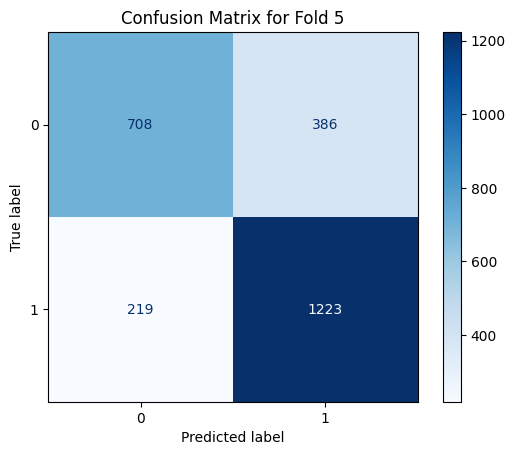

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for the last fold
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Plot confusion matrix
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix for Fold {fold}')
plt.show()


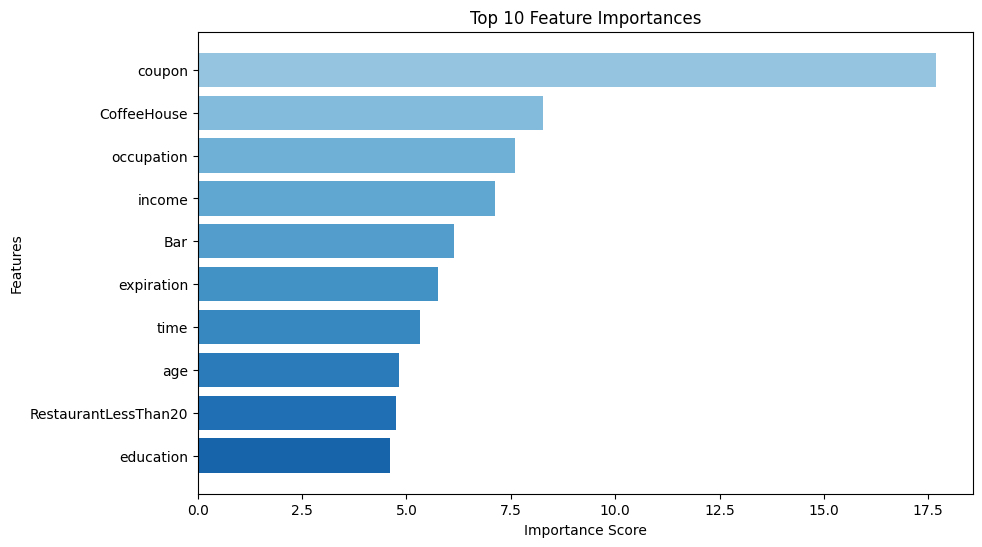

In [ ]:
# Calculate feature importance
feature_importances = model.get_feature_importance()
feature_names = X.columns

# Create a dataframe for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
# Generate a colormap (e.g., 'Blues' for blue gradient)
colors = plt.cm.Blues(np.linspace(0.4, 0.8, 10))  # Create gradient colors for top 10 features

# Plot each bar with the corresponding gradient color
for i, (feature, importance) in enumerate(zip(importance_df['Feature'][:10], importance_df['Importance'][:10])):
    plt.barh(feature, importance, color=colors[i])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()


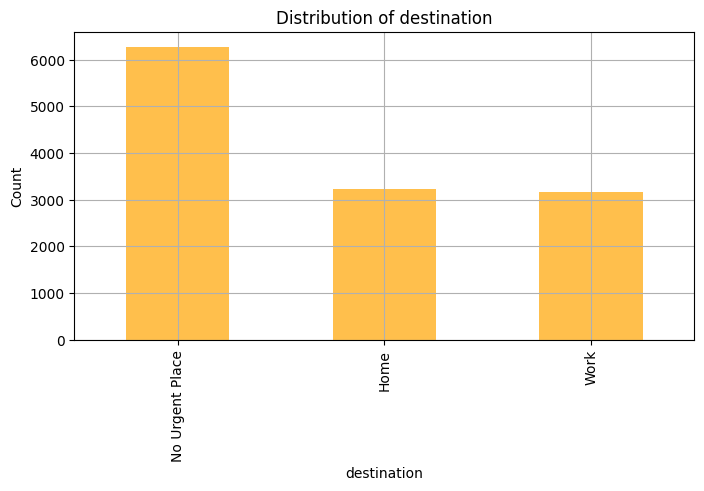

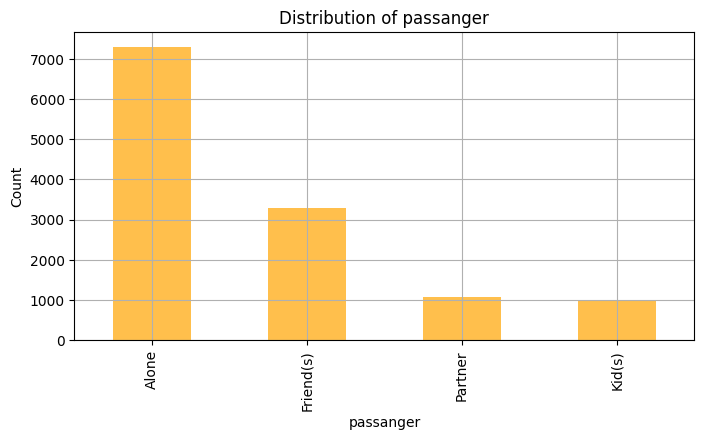

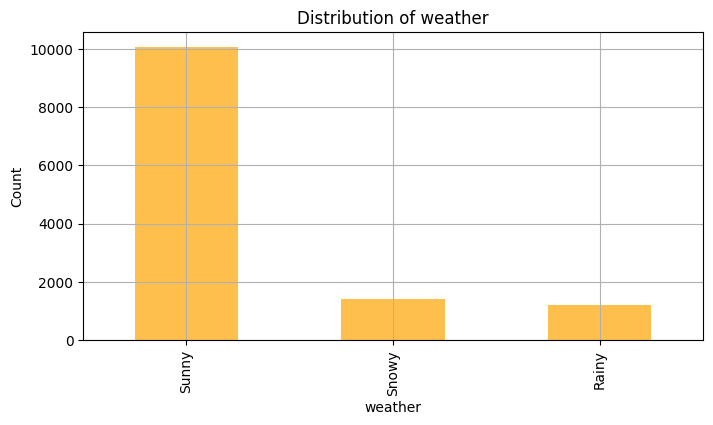

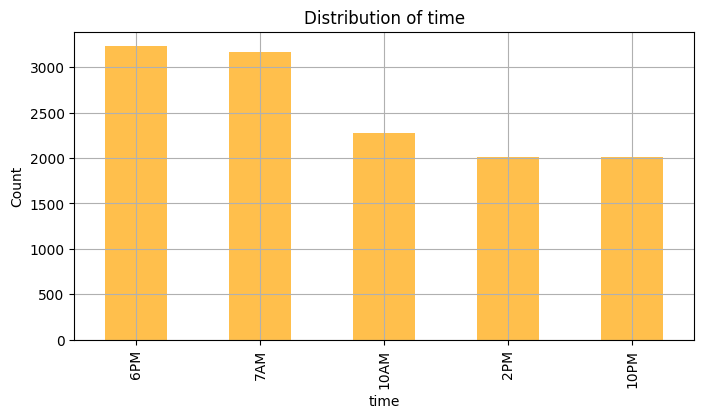

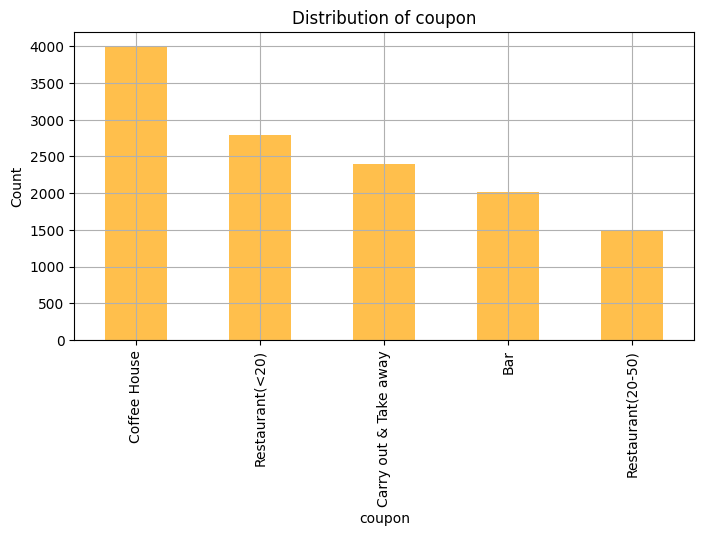

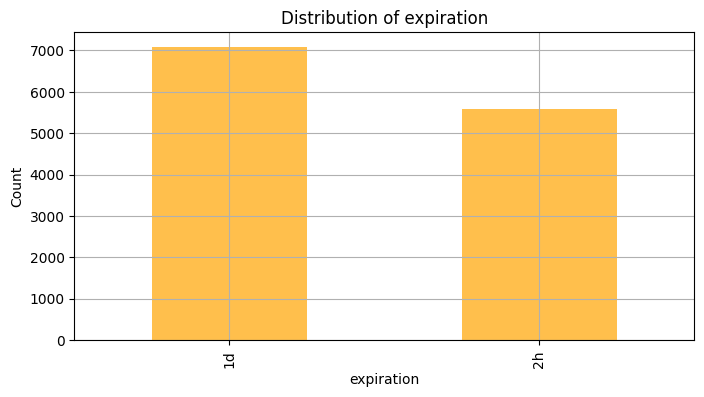

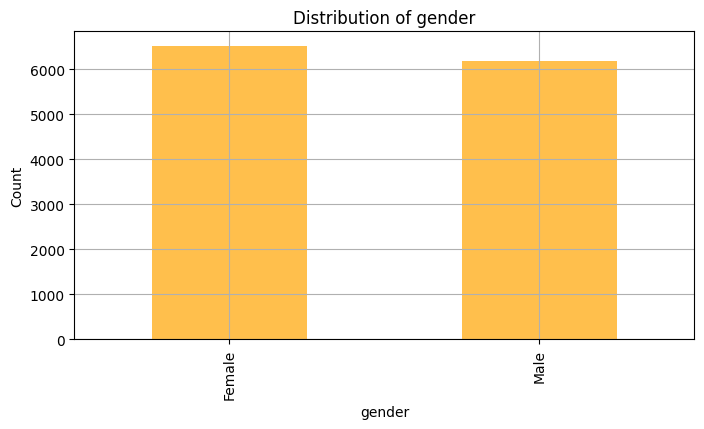

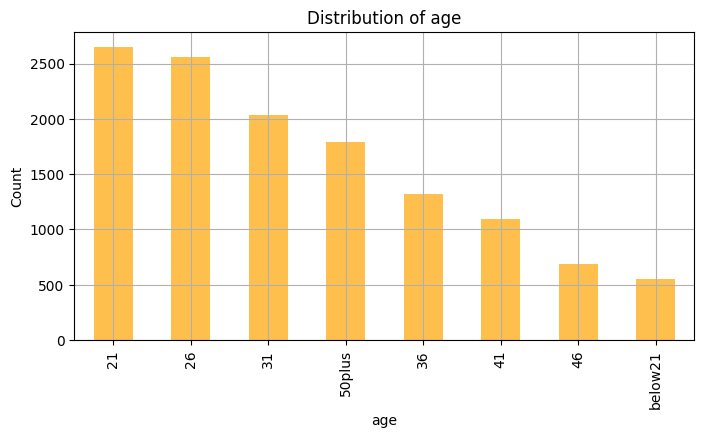

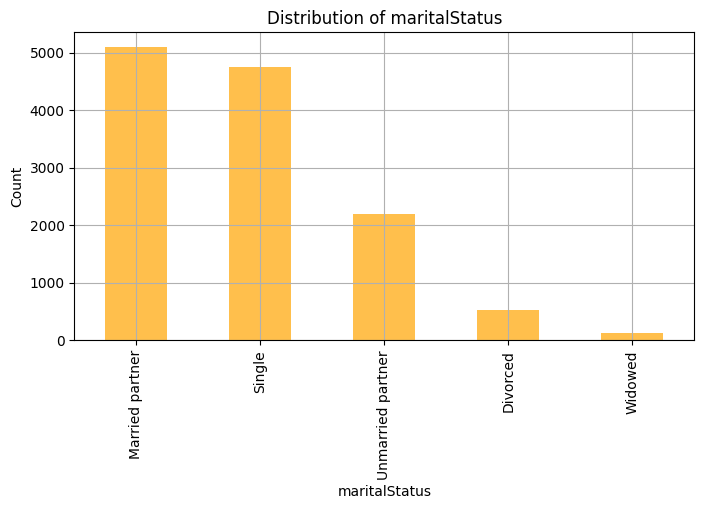

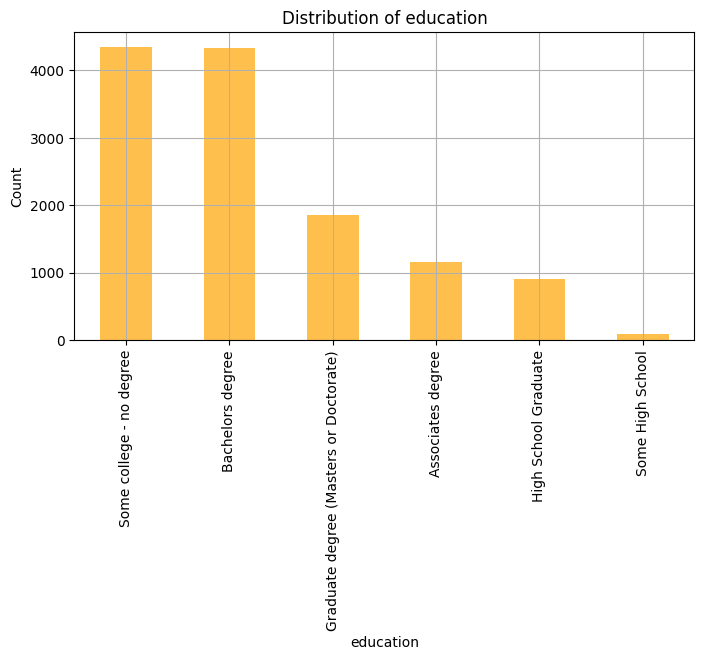

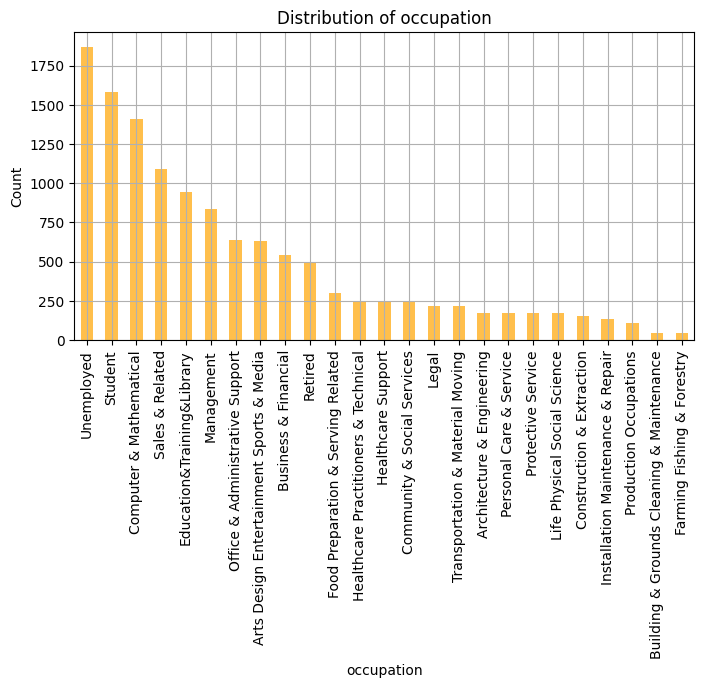

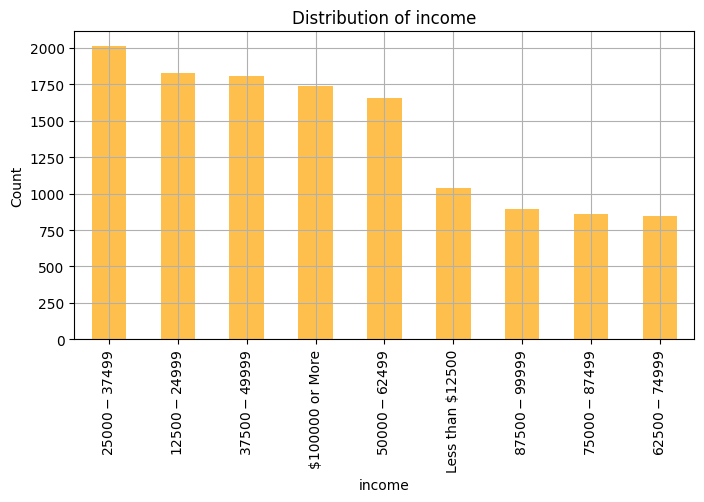

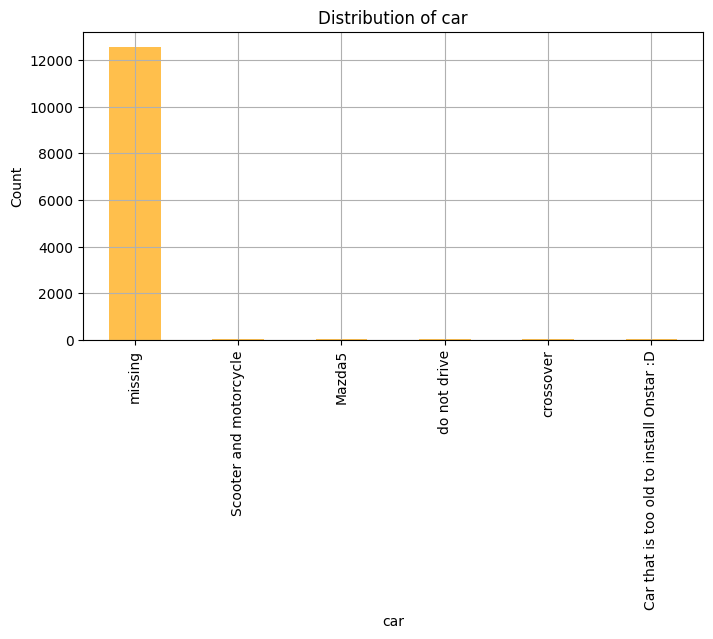

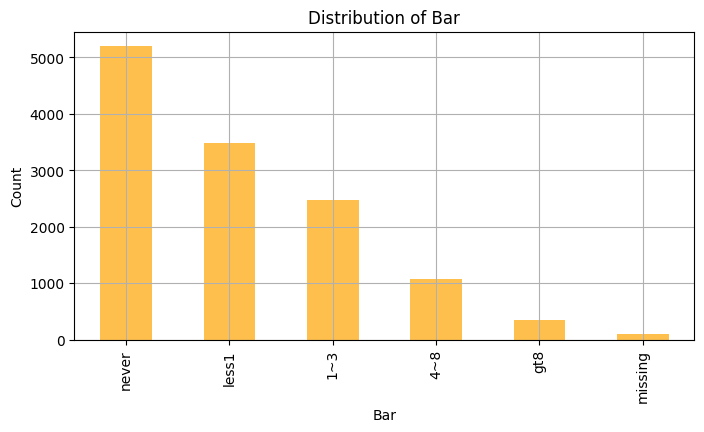

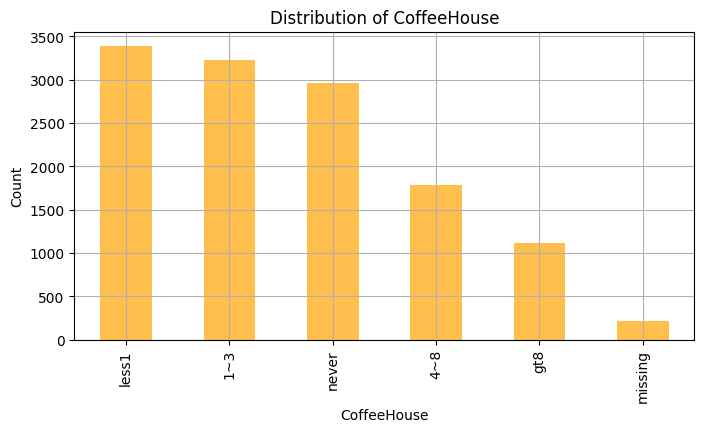

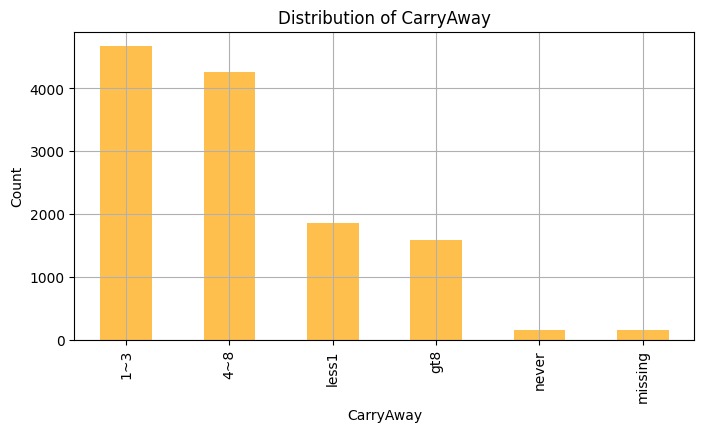

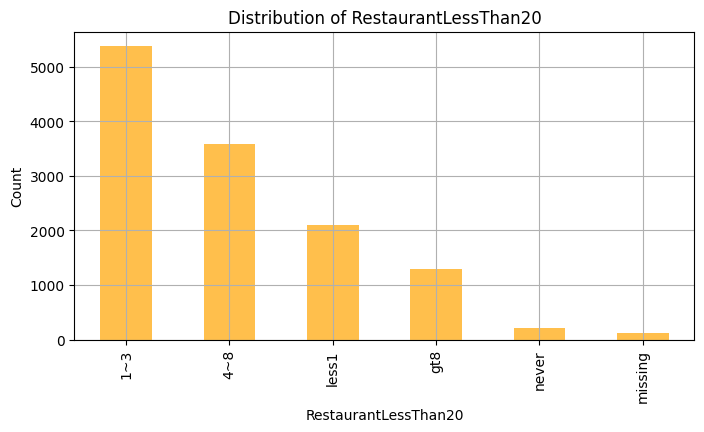

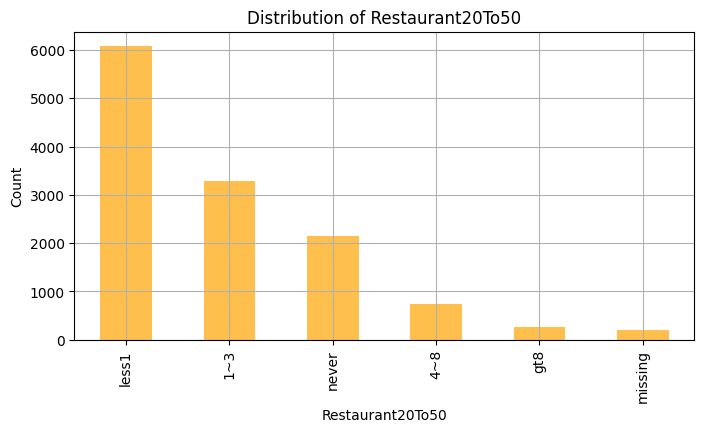

In [ ]:
# Visualize distribution of categorical features
for col in cat_features:
    plt.figure(figsize=(8, 4))
    data[col].value_counts().plot(kind='bar', color='orange', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid()
    plt.show()


### Part 4 Conclusion:
The integration of CatBoost with Stratified K-Fold cross-validation offers a robust framework for developing accurate and reliable in-vehicle coupon recommendation systems. By meticulously handling categorical data, addressing missing values, and employing rigorous validation techniques, the model demonstrates high performance, as evidenced by consistent F1 scores across multiple folds. This methodology ensures that the recommendation system not only excels on training data but also generalizes effectively to unseen user scenarios.

To further enhance model performance, future improvements could involve hyperparameter tuning using optimization libraries such as Optuna. This approach systematically searches for the optimal hyperparameters, potentially boosting the model's predictive capabilities. Additionally, incorporating more nuanced features—such as temporal user behavior or vehicle usage patterns—could enhance the personalization and relevance of coupon recommendations, leading to increased user engagement.

Understanding feature importance is crucial for interpreting model decisions and ensuring transparency. Implementing SHAP (SHapley Additive exPlanations) values can provide insights into how each feature contributes to the model's predictions. By analyzing SHAP values, one can identify which features have the most significant impact on the recommendation outcomes, facilitating better-informed business decisions and feature engineering.
SHAP

As the automotive industry continues to embrace data-driven strategies, such sophisticated machine learning models—augmented with interpretability tools like SHAP—will be instrumental in driving customer satisfaction and business growth.